In [30]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble, linear_model, preprocessing, cross_validation, neighbors, tree, svm
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

### This Notebook contains the minimal code necessary to accomplish the modeling. The process containing the decisions that led to this can be found in "Version 1"

The assignment here is to create a predictive model using Supervised Learning models learned so far to predict housing prices for the Melbourne Metropolitan area. The Kaggle dataset containend two CSVs. One of them contained a great deal of missing data such that it became largely useless. The other was missing about 25% of the Prices, but that still left it with over 29,000 observations. 

In [31]:
df2 = pd.read_csv('MELBOURNE_HOUSE_PRICES_LESS.csv')

In [32]:
df2 = df2.dropna()

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41196 entries, 0 to 52961
Data columns (total 12 columns):
Suburb           41196 non-null object
Address          41196 non-null object
Rooms            41196 non-null int64
Type             41196 non-null object
Price            41196 non-null float64
Method           41196 non-null object
SellerG          41196 non-null object
Date             41196 non-null object
Regionname       41196 non-null object
Propertycount    41196 non-null int64
Distance         41196 non-null float64
CouncilArea      41196 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 4.1+ MB


Preprocessing included limiting the DataFrame to observations that contained value 'h' for feature 'type'. All others were not houses, which is the assignment for this model. 

I also dropped columns that conained data that didn't add any value to the model such as the address, name of the seller, date of the listing, etc. Then I created dummies for the categorical features, one of which was the Suburb which will be a major factor later in this Notebook. 

In [34]:
df2 = df2.loc[df2['Type'] == 'h']

In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29207 entries, 0 to 52961
Data columns (total 12 columns):
Suburb           29207 non-null object
Address          29207 non-null object
Rooms            29207 non-null int64
Type             29207 non-null object
Price            29207 non-null float64
Method           29207 non-null object
SellerG          29207 non-null object
Date             29207 non-null object
Regionname       29207 non-null object
Propertycount    29207 non-null int64
Distance         29207 non-null float64
CouncilArea      29207 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 2.9+ MB


In [36]:
df2 = df2.drop(['Address', 'SellerG', 'Date', 'Regionname', 'Type', 'Suburb'], 1)

In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29207 entries, 0 to 52961
Data columns (total 6 columns):
Rooms            29207 non-null int64
Price            29207 non-null float64
Method           29207 non-null object
Propertycount    29207 non-null int64
Distance         29207 non-null float64
CouncilArea      29207 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 1.6+ MB


In [38]:
df2 = pd.get_dummies(data=df2, columns=['Method', 'CouncilArea'])

In [39]:
df2.head()

,Rooms,Price,Propertycount,Distance,Method_PI,Method_S,Method_SA,Method_SP,Method_VB,CouncilArea_Banyule City Council,...,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council
0,3,1490000.0,4019,3.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3,1220000.0,4019,3.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1420000.0,4019,3.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,1515000.0,1543,7.5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,670000.0,3464,10.4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X = df2.drop('Price', axis=1)
y = df2['Price']

In [41]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

Note in the following cell the removal of the Suburb column. Rather than show the long line of testing that was done to bring about this decision I'll just explain it here. 

This dataset contains a massive amount of outliers. So many that most models are very poor at handling them. Note that this dataset might be better served with clustering models that will come later in the Unsupervised Learning section. However, this assignment requires the use of SL modeling. 

The Suburb of the dataset contains hundreds of values, as anyone familiar with the Melbourne area would know. I considered it a possibility that to handle all of the outliers, which are right to exist in the data and should not be removed just to make the model "better", I should create a model for every suburb. There were 71 that had >200 Price observations. It's not a large number of observations, but it might still be better to model each suburb as there are several factors that affect housingn prices that are not present in this dataset (Average income, population, local industry, resident demographics, etc.). 

That said, here are the models that I ran having excluded the Suburb feature, but before running models for each suburb.

## Gradient Boosting without Suburbs (X, y)

In [42]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

clf = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, loss='huber', random_state=1)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6788992162797785

In [43]:
cross_val_score(clf, X_test, y_test, cv=10)

array([0.61364395, 0.68743723, 0.65297499, 0.60267996, 0.64670298,
       0.69075547, 0.70484685, 0.64576996, 0.67855121, 0.68125362])

This isn't bad, but hardly anything to report up as a success. The best news to take away here is the model's ability to display feature importance. 

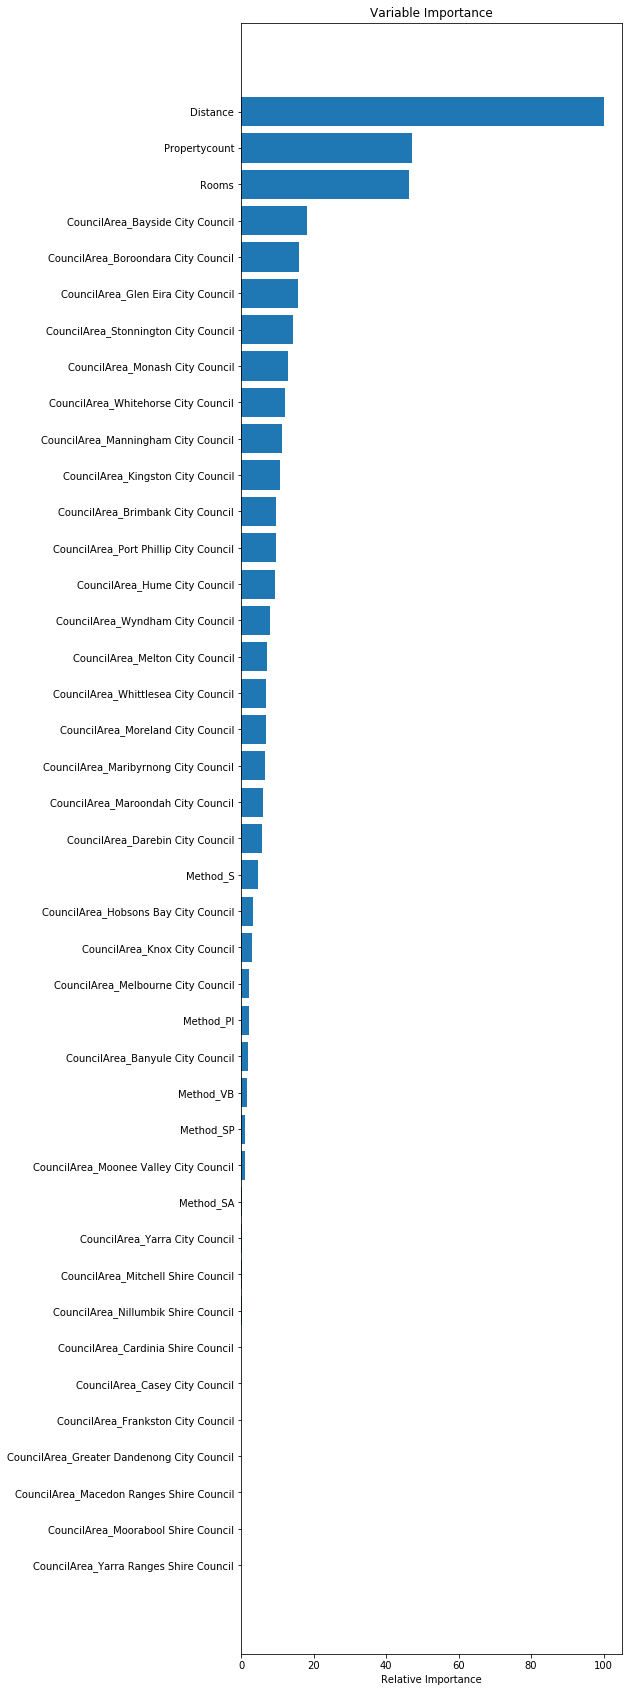

In [44]:
feature_importance = clf.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15,30))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Distance from city center is the most important feature. Number of rooms is second by a moderate amount. Whether or not the house is within the jurisdiction of the Bayside City Council is down quite a lot from the Distance. And everything else matters not one little bit. I'll run a PCA just to be sure. However, I have my doubts that it will add much value to our model since there are only three features that seem to be influencing our prices to any extent. 

### NOTE: 

The processing of additional models after this point and inclusion of PCA is more of an exercise of my understanding of the models. I do not expect them to predict housing very well given the low feature relevance and the number of outliers. 

## Gradient Boosting (X_pca, y)

In [45]:
pca = PCA(n_components=30)
X_pca = pd.DataFrame(pca.fit_transform(X))

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.2, random_state=1)

In [47]:
decision_tree = tree.DecisionTreeRegressor(max_depth=2)
decision_tree.fit(X_train, y_train)

decision_tree.score(X_test, y_test)

0.3326970851588744

In [48]:
cross_val_score(decision_tree, X_test, y_test, cv=10)

array([0.33308316, 0.28069995, 0.30663957, 0.3295295 , 0.3313005 ,
       0.33026489, 0.33014281, 0.33922263, 0.32039426, 0.29964428])

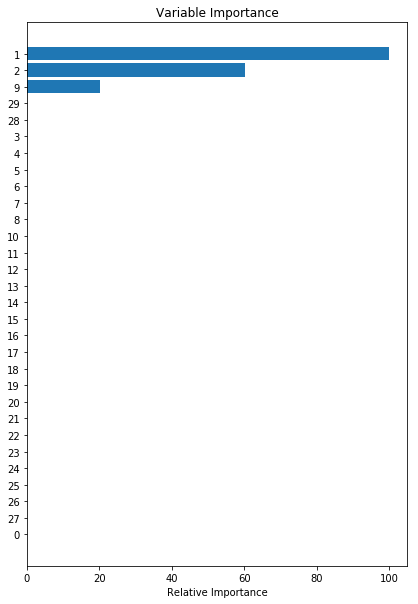

In [49]:
feature_importance = decision_tree.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_pca.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Look at that. The similarity between X and X_pca is virtually nonexistent as expected. I'll run a Lasso and ridge regression next.

## LASSO Regression

In [50]:
#Don't forget to reset our train, test split to X and y instead of X_pca
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [51]:
print('\nR-squared  model, range of alpha: .00001 to 1')
alphas = [1e-5, 1e-3, .01, .05, 1]

for i in alphas:
    lass = linear_model.Lasso(alpha=i)
    lassfit = lass.fit(X_train, y_train)
    print(('R2 Score for alpha {}').format(i))
    print(lass.score(X_train, y_train))
    print('\n')


R-squared  model, range of alpha: .00001 to 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2 Score for alpha 1e-05
0.5887952807782686


R2 Score for alpha 0.001
0.5887952807782423


R2 Score for alpha 0.01
0.5887952807756442


R2 Score for alpha 0.05
0.5887952807126597


R2 Score for alpha 1
0.588795254534778




That warning is a problem. Let's increase our tol and rerun it. If that doesn't help, I'll do as it says and increase my max iterations

In [52]:
#I ran this with tol=0.01 first (default is .0001). No effect. Trying again with tol=.1

# print('\nR-squared  model, range of alpha: .05 to 10')
# alphas = [.05, 1, 10]

# for i in alphas:
#     lass = linear_model.Lasso(alpha=i, tol=.1)
#     lassfit = lass.fit(X_train, y_train)
#     print(('R2 Score for alpha {}').format(i))
#     print(lass.score(X_train, y_train))
#     print('\n')

In [53]:
# print('\nR-squared  model, range of alpha: .05 to 10')
# alphas = [.05, 1, 10]

# for i in alphas:
#     lass = linear_model.Lasso(alpha=i, max_iter=2000)
#     lassfit = lass.fit(X_train, y_train)
#     print(('R2 Score for alpha {}').format(i))
#     print(lass.score(X_train, y_train))
#     print('\n')

I have run this loop of alphas three ways and the result is the same every time. Regardless of the inherent value of the score (68.3%) there should be some change based on these argument differences ordinarily which leads me to believe that the features that would ordinarily be shrunk by the process are already having a negligible effect at full force. I'll try running it with PCA. 

## LASSO Regression (X_pca, y)

In [54]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_pca, y,test_size=0.2)

In [55]:
alphas = [.05, 1, 10]

for i in alphas:
    lass = linear_model.Lasso(alpha=i, tol=.1)
    lassfit = lass.fit(X_train, y_train)
    print(('R2 Score for alpha {}').format(i))
    print(lass.score(X_train, y_train))
    print('\n')

R2 Score for alpha 0.05
0.5816206842235485


R2 Score for alpha 1
0.5816206821873132


R2 Score for alpha 10
0.5816204800955385




I've run the LASSO regression for the PCA several ways:

- alpha=.05, tol=.0001, max_iter=1000
- alpha=.05, tol=.01, max_iter=1000
- alpha=.05, tol=.1, max_iter=1000
- alpha=1, tol=.0001, max_iter=1000
- alpha=1, tol=.01, max_iter=1000
- alpha=1, tol=.1, max_iter=1000
- alpha=10, tol=.0001, max_iter=1000
- alpha=10, tol=.0001, max_iter=1000
- alpha=10, tol=.0001, max_iter=1000
- alpha=.05, tol=.0001, max_iter=2000
- alpha=1, tol=.0001, max_iter=2000
- alpha=10, tol=.0001, max_iter=2000

None of these permutations have had any impact on the model R2 score (57.6% every time). 

### Lasso Conclusion:

I wasn't expecting much out of this model since there are so few features that matter already. But it's good to see that the regression operated as expected. 

## Ridge Regression (X, y)

In [56]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [57]:
#RIDGE REGRESSIONS 
print('\nR-squared Ridge Regression, range of alpha: 10 to 0.01\n')
alphas = [10, 5, .5, .05, .01]

for i in alphas:
    ridgeregr = linear_model.Ridge(alpha=i, fit_intercept=False) 
    ridgeregr.fit(X_train, y_train)
    print(('R2 Score for alpha {}').format(i))
    print(ridgeregr.score(X_train, y_train))
    print('\n')


R-squared Ridge Regression, range of alpha: 10 to 0.01

R2 Score for alpha 10
0.5909539447074851


R2 Score for alpha 5
0.5912552329718471


R2 Score for alpha 0.5
0.5914032965849392


R2 Score for alpha 0.05
0.5914056738019795


R2 Score for alpha 0.01
0.5914056988312074




I'm running into the same issues time and time again. Too few relevant features and too many outliers. On to KNN.

## KNN (X, y)

In [58]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [59]:
print('\nKNN Regression Score, range of neighbors: 2, 5, 10, 20')
n = [2, 5, 10, 20]

for i in n:
    neigh = KNeighborsRegressor(n_neighbors=i)
    neigh.fit(X_train, y_train)
    print(('R2 Score for n_neighbors {}').format(i))
    print(neigh.score(X_test, y_test))
    print('\n')


KNN Regression Score, range of neighbors: 2, 5, 10, 20
R2 Score for n_neighbors 2
0.6037068655526754


R2 Score for n_neighbors 5
0.6751009676281234


R2 Score for n_neighbors 10
0.6952508493239372


R2 Score for n_neighbors 20
0.6959204805486705




Diminishing returns after we set n_neighbors to 10. This is the best predictor so far and the one that I would recommend for the dataset as a whole. 

## SVM (X_pca, y)

Why am I running Support Vector Machine for this dataset? Yes, it's 400 features wide. But it's 29K observations deep. That kind of dataset is not ideal for SVM. I'll reduce the features to 30 with PCA and run the model. This won't increase its predictive powers. But it should decrease the processing time. 

In [60]:
pca = PCA(n_components=30)
X_pca = pd.DataFrame(pca.fit_transform(X))

In [61]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_pca, y,test_size=0.2)

In [62]:
svr = SVR()
svr.fit(X_train, y_train)

svr.score(X_test, y_test)

-0.06940687770520526

As expected, SVM is not a good model for this dataset. Let's try something better suited to the shape of our data, Random Forest.

## Random Forest (X, y)

In [63]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [64]:
print('\nKNN Regression Score, range of neighbors: 5, 10, 20, 40\n')
n = [5, 10, 20, 40]

for i in n:
    rfr = ensemble.RandomForestRegressor(n_estimators=i)
    rfr.fit(X_train, y_train)
    print(('R2 Score for number of decision trees {}').format(i))
    print(rfr.score(X_test, y_test))
    print('\n')


KNN Regression Score, range of neighbors: 5, 10, 20, 40

R2 Score for number of decision trees 5
0.6900883308210984


R2 Score for number of decision trees 10
0.7014575908584808


R2 Score for number of decision trees 20
0.7085790757505723


R2 Score for number of decision trees 40
0.7080083533147168




## Random Forest (X_pca, y)

In [65]:
pca = PCA(n_components=30)
X_pca = pd.DataFrame(pca.fit_transform(X))

In [66]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [67]:
print('\nKNN Regression Score, range of neighbors: 5, 10, 20, 40\n')
n = [5, 10, 20, 40]

for i in n:
    rfr = ensemble.RandomForestRegressor(n_estimators=i)
    rfr.fit(X_train, y_train)
    print(('R2 Score for number of decision trees {}').format(i))
    print(rfr.score(X_test, y_test))
    print('\n')


KNN Regression Score, range of neighbors: 5, 10, 20, 40

R2 Score for number of decision trees 5
0.7135104264312877


R2 Score for number of decision trees 10
0.7132856038385218


R2 Score for number of decision trees 20
0.7209529792338785


R2 Score for number of decision trees 40
0.720667439007602




Here is an example of what makes Random Forest so powerful. In some models, reducing the feature space through PCA eliminates unwanted noise and makes the predictive power of a model stronger, while reducing the processing time and computational cost. Random Forests deal with larger feature spaces quickly and efficiently, making good use of the information offered by each. This is made clear here where we can see that our model based on X outperformed the model based on X_pca. 

## Dataset Conclusion (No Suburb Breakdown)

Lasso, KNN, and Random Forest all showed similar predictive power with R2 scores reliably between 68-72%. Ridge regressions were all in 67the percentile. 

The biggest challenge here is predicting the entire Melbourne housing market. The number of outliers is extremely problematic. I would imagine that if for each value of features 'Suburb' or 'Regionname' I created models to predict housing values I might be able to dial in a bit better. 

This would really only be a matter of creating new DataFrames for each suburb and then creating a series of models for that. There are several Suburb values that contain only a few observations. Those could be omitted. I could probably reintegrate the 'Type' and other dropped features. Since all of these models seem to perform similarly, I could try out a couple suburbs to confirm that similarity and choose the one that has the fastest processing time (in this case SVR wouldn't be an immediate reject because of the low number of observations) and run a loop to call in each DataFrame. 

In [68]:
df2 = pd.read_csv('MELBOURNE_HOUSE_PRICES_LESS.csv')

## Creating DataFrames for each Suburb with >= 200 observations

preprocess df2 as before, dropping columns, making dummies. 

In [69]:
df2 = df2.dropna()
df2 = df2.drop(['Address', 'SellerG', 'Date', 'Type', 'Regionname'], 1)
df2 = pd.get_dummies(data=df2, columns=['Method', 'CouncilArea'])

In [70]:
# df2['Suburb'].value_counts()[:75]

In [71]:
df2.head()

,Suburb,Rooms,Price,Propertycount,Distance,Method_PI,Method_S,Method_SA,Method_SP,Method_VB,...,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council
0,Abbotsford,3,1490000.0,4019,3.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Abbotsford,3,1220000.0,4019,3.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Abbotsford,3,1420000.0,4019,3.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Aberfeldie,3,1515000.0,1543,7.5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Airport West,2,670000.0,3464,10.4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# df2['Suburb'].unique()

In [73]:
suburbs = df2['Suburb'].unique()

In [74]:
#create a list for suburb names
subnames = []

In [75]:
#create a list for the suburbs with >200 observations
subs = []

In [76]:
#Create the list of suburbs
for suburb in suburbs:
    df = df2[df2['Suburb'] == suburb]
    if df.shape[0] >= 200:
        subs.append(df.drop('Suburb', axis=1))
        subnames.append(suburb)

In [79]:
len(subs)

71

In [80]:
zipsub = list(zip(subnames, subs))

In [81]:
len(zipsub)

71

In [82]:
submodels = []

### Random Forest for each Suburb

In [83]:
# Run a Random Forest on each Suburb

for name,df in zipsub:
    #unpacks the zip in the order specified (name, then dataframe)
#     c += 1
    X = df.drop('Price', axis=1)
    y = df['Price']
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)
    rfr = ensemble.RandomForestRegressor(n_estimators=5)
    rfr.fit(X_train, y_train)
    submodels.append((name, rfr.score(X_test, y_test)))
    

results = pd.DataFrame.from_records(submodels, columns=['Suburb', 'Model R2 Score'])    
    
#     print(c, name)
#     print(rfr.score(X_test, y_test))
#     print('\n')

In [85]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
Suburb            71 non-null object
Model R2 Score    71 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [86]:
results.tail()

,Suburb,Model R2 Score
66,Williamstown,0.452201
67,Yarraville,0.529755
68,Cheltenham,0.383472
69,Sunbury,0.062035
70,Hawthorn East,0.759376


In [87]:
results[results['Suburb'] == 'Sunshine']

,Suburb,Model R2 Score
58,Sunshine,0.429185


In [88]:
results.head()

,Suburb,Model R2 Score
0,Ascot Vale,0.639414
1,Balwyn,0.474740
2,Balwyn North,0.251893
3,Beaumaris,0.302846
4,Bentleigh,0.468146


In [89]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(results)

              Suburb  Model R2 Score
0         Ascot Vale        0.639414
1             Balwyn        0.474740
2       Balwyn North        0.251893
3          Beaumaris        0.302846
4          Bentleigh        0.468146
5     Bentleigh East        0.354508
6           Brighton        0.524679
7      Brighton East        0.358367
8          Brunswick        0.525222
9     Brunswick West        0.449170
10          Bundoora        0.445063
11        Camberwell        0.667854
12          Carnegie        0.650562
13            Coburg        0.117852
14       Craigieburn        0.284678
15           Croydon       -0.128408
16         Doncaster        0.156800
17    Doncaster East        0.358419
18            Elwood        0.750728
19            Epping        0.189686
20          Essendon        0.642735
21           Fawkner        0.068529
22         Footscray        0.543151
23         Frankston        0.088963
24         Glen Iris        0.738154
25     Glen Waverley        0.270542
2

Some of these models predicted well. Some predicted not so well. And some are just lousy. These outliers and now the low number of observations are proving a real challenge. 

In [95]:
subnames = []
subs = []

for suburb in suburbs:
    df = df2[df2['Suburb'] == suburb]
    if df.shape[0] >= 200:
        subs.append(df.drop('Suburb', axis=1))
        subnames.append(suburb)
        
zipsub = list(zip(subnames, subs))

submodels = []

In [96]:
for name,df in zipsub:
    #unpacks the zip in the order specified (name, then dataframe)
#     c += 1
    X = df.drop('Price', axis=1)
    y = df['Price']
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)
    clf = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, loss='huber', random_state=1)
    clf.fit(X_train, y_train)
    submodels.append((name, clf.score(X_test, y_test)))

In [97]:
results = pd.DataFrame.from_records(submodels, columns=['Suburb', 'Model R2 Score'])  

In [98]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(results)

              Suburb  Model R2 Score
0         Ascot Vale        0.382420
1             Balwyn        0.640954
2       Balwyn North        0.093990
3          Beaumaris        0.250175
4          Bentleigh        0.406167
5     Bentleigh East        0.443835
6           Brighton        0.458646
7      Brighton East        0.373662
8          Brunswick        0.579383
9     Brunswick West        0.532558
10          Bundoora        0.451315
11        Camberwell        0.464591
12          Carnegie        0.712230
13            Coburg        0.538467
14       Craigieburn       -0.007741
15           Croydon        0.172114
16         Doncaster        0.265273
17    Doncaster East        0.285405
18            Elwood        0.730510
19            Epping        0.388413
20          Essendon        0.606624
21           Fawkner       -0.039999
22         Footscray        0.310110
23         Frankston       -0.254945
24         Glen Iris        0.647350
25     Glen Waverley        0.418665
2

## Conclusion (Suburb Breakdown)

Though I still believe that a suburban modeling structure is the best fit for any realistic housing price model, I see that there are problems with the dataset:

- too many factors that can affect housing price that are missing
- too few observations
- outliers must be dealt with in ways that Supervised Learning models alone might not be equipped for

The next recommendation is that new data be scraped and added to regional demographic information. Things like address and seller are irrelevant. Features like per capita household income, employment rates, square footage, and even sales trend data are far more important. 